In [1]:
import numpy as np
import pandas as pd
import pydicom
import nibabel as nib

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob



The goal is to identify fractures in CT scans in the cervical spine at the same level of accuracy as radiologists.
<p align="center">
  <img src="https://github.com/elizabethwillard/rsna-cervical-spine-detection/blob/main/Images/Spine.png?raw=true">
</p>

Specifically, we are looking at C1-C7. We also want the overall probability any fractures in the cervical spine. 

>The submission will be evaluated using a weighted multi-label logarithmic loss. The binary weighted log loss function for label j on exam i is specified as:
$$
L_{ij} = - w_j \left(y_{ij} \log(p_{ij}) + (1-y_{ij}) \log(1-p_{ij})  \right)
$$
Loss is averaged across all rows

There are also some weights associated with this: 
>Category: Weight
Vertebrae negative: 1
Vertebrae positive: 2
Patient negative: 7
Patient positive: 14

[Competition Link](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/overview/description)


In [4]:
train = pd.read_csv("/mnt/d/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bb = pd.read_csv("/mnt/d/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
id_num = "1.2.826.0.1.3680043.1363"

train.loc[train["StudyInstanceUID"] == id_num]
#Some of the rows have an indication where the spine is fractured
#Select a specific patient ID to look at the bounding boxes + where the fracture is 

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


A dicom file consists of a header (demographic info for patient + acquisition, dimensions, matrix size) and a single attribute for pixel intensity data
<p align="center">
  <img src="https://github.com/elizabethwillard/rsna-cervical-spine-detection/blob/main/Images/DicomExplained.jpg?raw=true">
</p>



We know that these files are $\leq$ 1 mm slice thickness. We also have axial orientation and bone kernel. 

In [5]:
train["StudyInstanceUID"].nunique()
#Number of unique study instances (aka patient images)

2019

In [6]:
#Looking at an example of the meta data included 
img = pydicom.dcmread(f"/mnt/d/rsna-2022-cervical-spine-fracture-detection/train_images/{id_num}/120.dcm")
print(img)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.1363.1.120
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.1363.1.120
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183912.555083'
(0010, 0010) Patient's Name                      PN: '1363'
(0010, 0020) Patient ID                          LO: '1363'
(0018, 0050) Slice Thickness                     DS: '1.0'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3

We can now see the file meta information derived from the header of this dicom image. The tag "Media Storage SOP Instance UID" (in this case:  UI: 1.2.826.0.1.3680043.14.1.1) and "Transfer Syntax UID" tell us that this image can unpacked using lossless JPEG conversion. We need GDCM and pylibjpeg 

>Image Position (Patient)            DS: [-73.87109375, -222.37109375, 620] 

Gives the x-axis, y-axis, and the z-axis. Z-axis shows the position in the sagittal plane, but the image is shown in the axial plane

We also know that the images are 512 x 512, that will impact the preprocessing for modelling. We need to calculate the voxel size + transform the data into Hounsfield Units since a CT-scan tells us about the radiodensity of an object 

In [7]:
bound_box = (train_bb[train_bb["StudyInstanceUID"] == id_num]).reset_index()


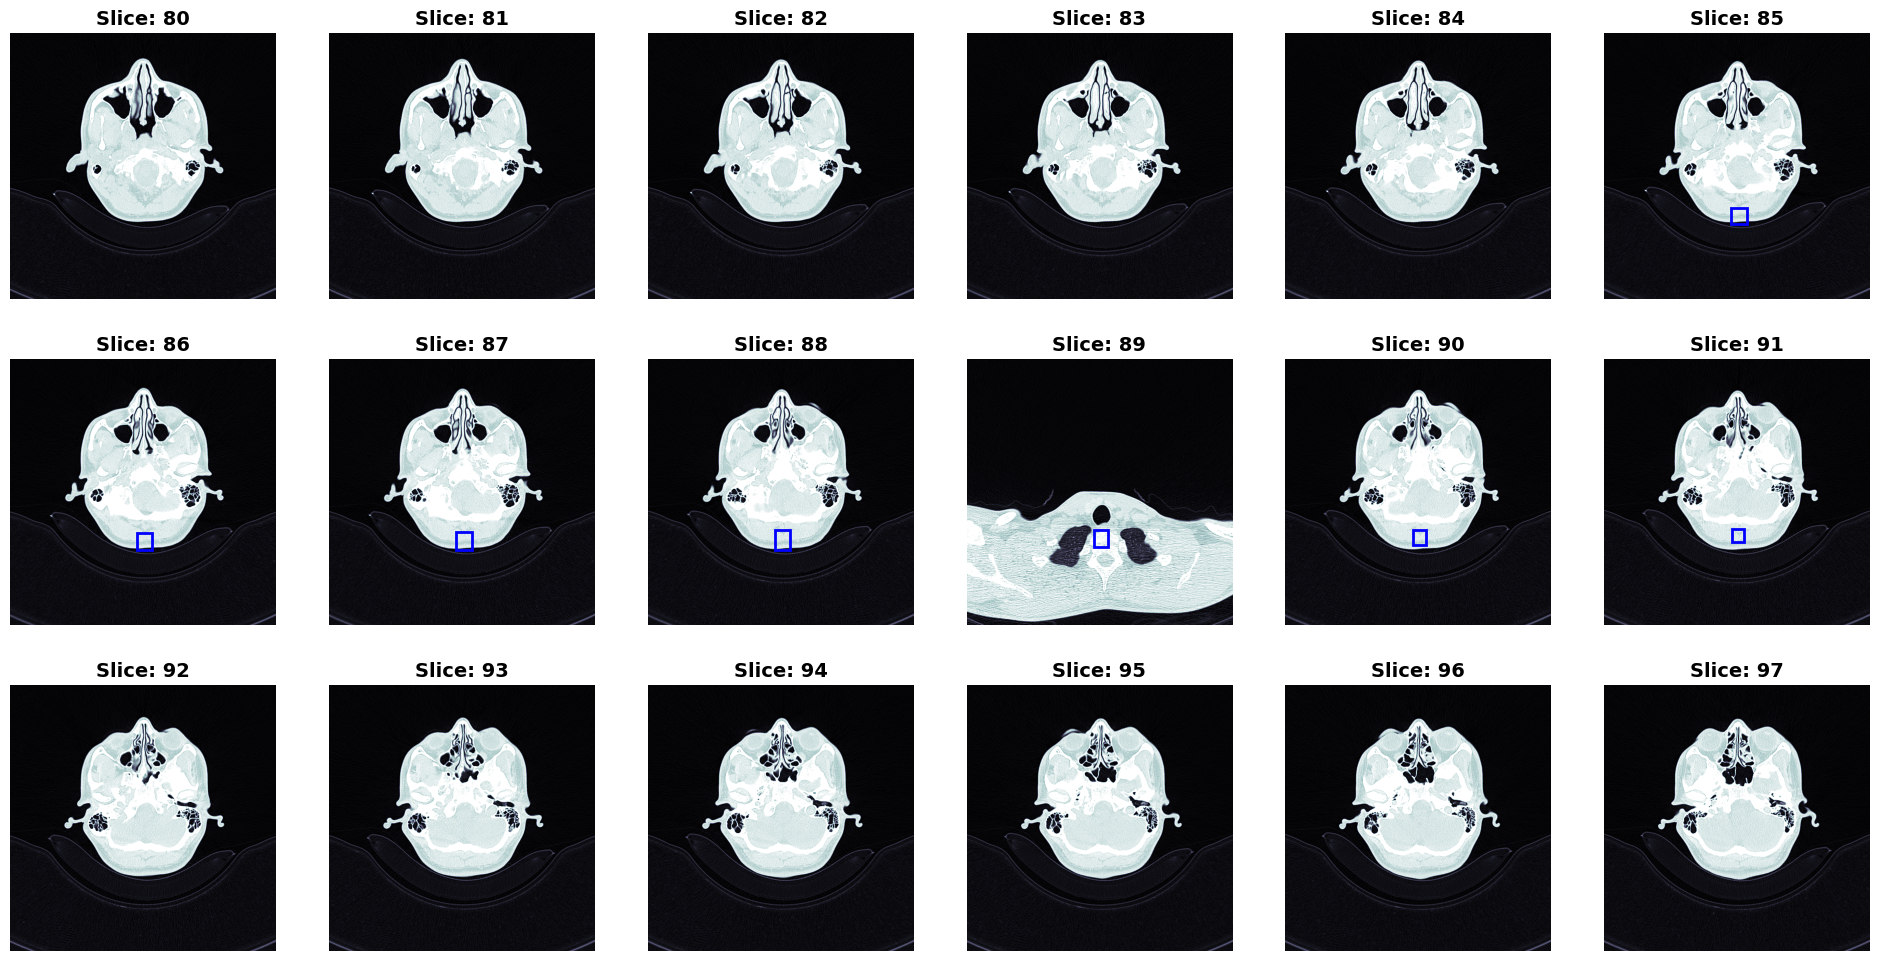

In [9]:
#https://github.com/pydicom/pydicom/blob/master/examples/image_processing/reslice.py
paths = glob(f"/mnt/d/rsna-2022-cervical-spine-fracture-detection/train_images/{id_num}/*.dcm")
files = [pydicom.dcmread(path) for path in paths]
images = [pydicom.pixel_data_handlers.apply_voi_lut(file.pixel_array, file) for file in files]

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))

start = 80
j = 0
for i in range(start,start+18):
    
    img = images[i]
    file = files[i]
    slice_num = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6
    for j in range(len(bound_box["slice_number"])):
        bb_value = bound_box.loc[j]["slice_number"].astype(int)
        if (bb_value == slice_num):
                bb_x = bound_box.iloc[j]["x"].astype(float)
                bb_y = bound_box.iloc[j]["y"].astype(float)
                width = bound_box.iloc[j]["width"].astype(float)
                height = bound_box.iloc[j]["height"].astype(float)
                rect = patches.Rectangle((bb_x, bb_y), width, height, fill=False, edgecolor="blue", linewidth=2)
                axes[x, y].add_patch(rect)
    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_num}", fontsize=14, weight='bold')
    axes[x, y].axis('off')
    #Each folder is one patient, and the image shown below is in the axial plane

The segmentations folder contains segmentations for all slices in a scan in the nifti file format. They were segmented automatically using a 3D UNET model, and radiologists modified and approved the segmentations. However, we need to be careful about the orientation of each.
>Please be aware that the NIFTI files consist of segmentation in the sagittal plane, while the DICOM files are in the axial plane.



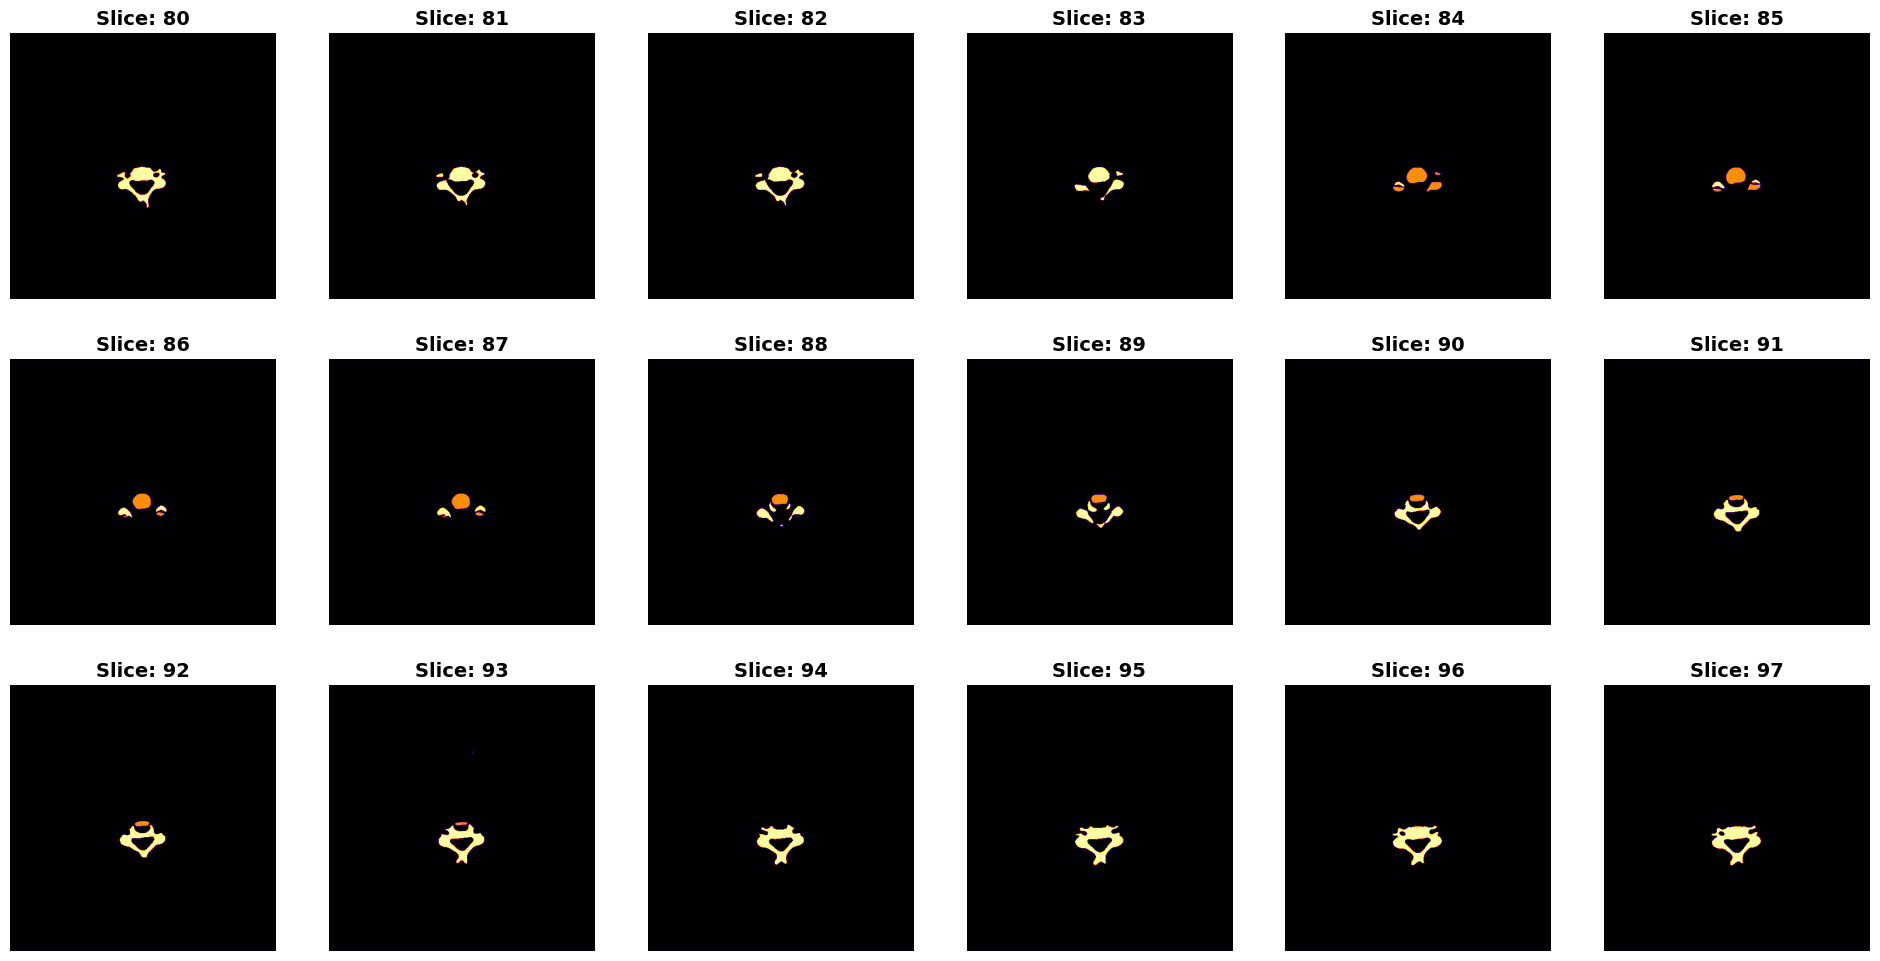

In [10]:
#Load segmentation + transpose it to align it with the axial plane image
seg_path = f"/mnt/d/rsna-2022-cervical-spine-fracture-detection/segmentations/{id_num}.nii"
ex = nib.load(seg_path)
seg = ex.get_fdata()
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
start = 80
for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [11]:
np.unique(seg[85])

array([0., 3., 4.])

This output of 0,3,4 implies that we are seeing an overlap between C3 and C4

Some notes from research review:
- Utilize a FCN ([long and short skip connections speed up the convergence of the learning process](https://arxiv.org/pdf/1608.04117.pdf)) ResNet50 - LSTM and [HMM](https://pubmed.ncbi.nlm.nih.gov/31283477/) 

- ResNet50 architecture will feature extract and  classify the spine (replace the FC layer of Resnet34 with two FC layers, each being followed by batch normalization and ReLU function)[1](https://pubmed.ncbi.nlm.nih.gov/33993335/)
    - Initial learning rate 0.01 with mini-batch of 192, reduced in half when no improvement on validation set for 30 epochs
    - The first FC layer reduces 512 to 32 and the second will reduce dimensionality to scalar value
    - Train CNN to make slice-level classification by minimizing binary cross-entropy loss
    - Also will want to use ADAM (0.9, 0.999, 1e-8)
    - Train for 400 epochs
    - [Ref](https://pubmed.ncbi.nlm.nih.gov/29758455/)
- then an bidirectional LSTM-RNN will run on the resulting probability of the presence of a fracture
    - 256 hidden units use 600 epoch
- Also don't forget to take some of the training for validation

In [12]:
print(train_bb["StudyInstanceUID"].nunique())

235
